In [1]:
# from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import re
import numpy as np

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:
res = models.resnet50(pretrained=True)

In [4]:
blks = list(res.children())

In [5]:
batch_size = 32
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

trainset = torchvision.datasets.ImageFolder(root='../data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [6]:
res = res.eval().cuda()

In [7]:
from tqdm import tqdm

In [8]:
pre_pool_outs = []
for batch, _ in tqdm(iter(trainloader)):
    out = Variable(batch).cuda()
    for i, layer in enumerate(blks):
        if isinstance(layer, torch.nn.modules.linear.Linear):
            out = out.view(out.size(0), -1)
        out = layer(out)
        if i == 8:
            pre_pool_outs.append(out.squeeze().data.cpu().numpy())

100%|██████████| 256/256 [01:03<00:00,  4.03it/s]


In [9]:
pre_pool_outs[0].shape

(32, 2048)

In [11]:
to_plot = np.vstack(pre_pool_outs[0:10])

In [12]:
to_plot.shape

(320, 2048)

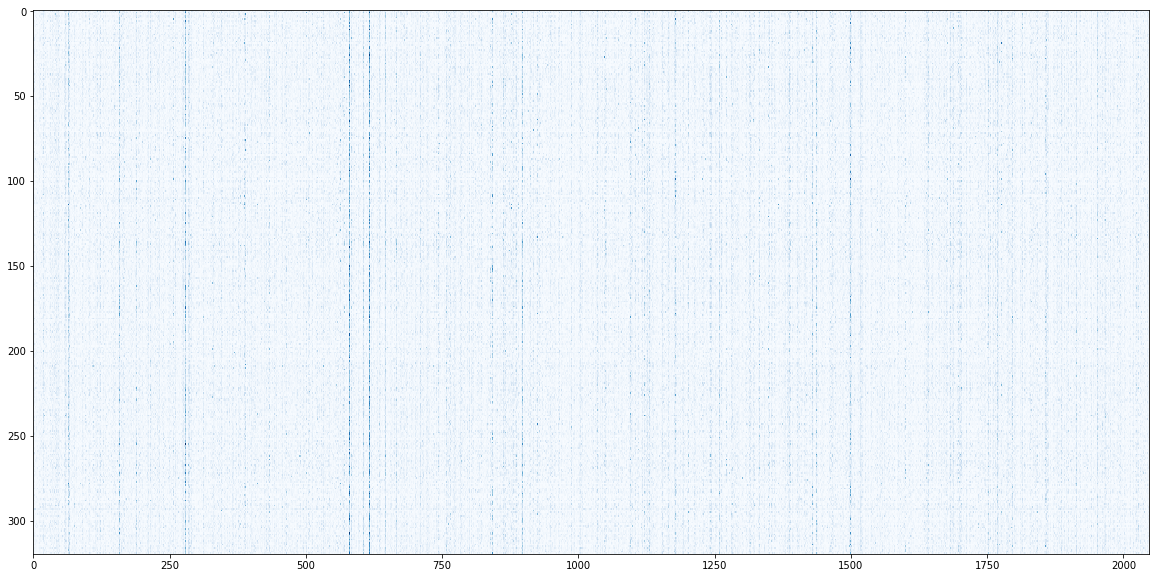

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(to_plot,cmap='Blues',aspect='auto')

In [19]:
low_level_conv = []
for batch, _ in tqdm(iter(trainloader)):
    out = Variable(batch).cuda()
    for i, layer in enumerate(blks):
        if isinstance(layer, torch.nn.modules.linear.Linear):
            out = out.view(out.size(0), -1)
        out = layer(out)
        if i == 4:
            out = torch.nn.functional.avg_pool2d(out, kernel_size=56)
            low_level_conv.append(out.squeeze().data.cpu().numpy())
            break

100%|██████████| 256/256 [00:20<00:00, 12.67it/s]


In [20]:
low_level_conv[0].shape

(32, 256)

In [21]:
to_plot_low = np.vstack(low_level_conv[5:20])

In [22]:
to_plot_low.shape

(480, 256)

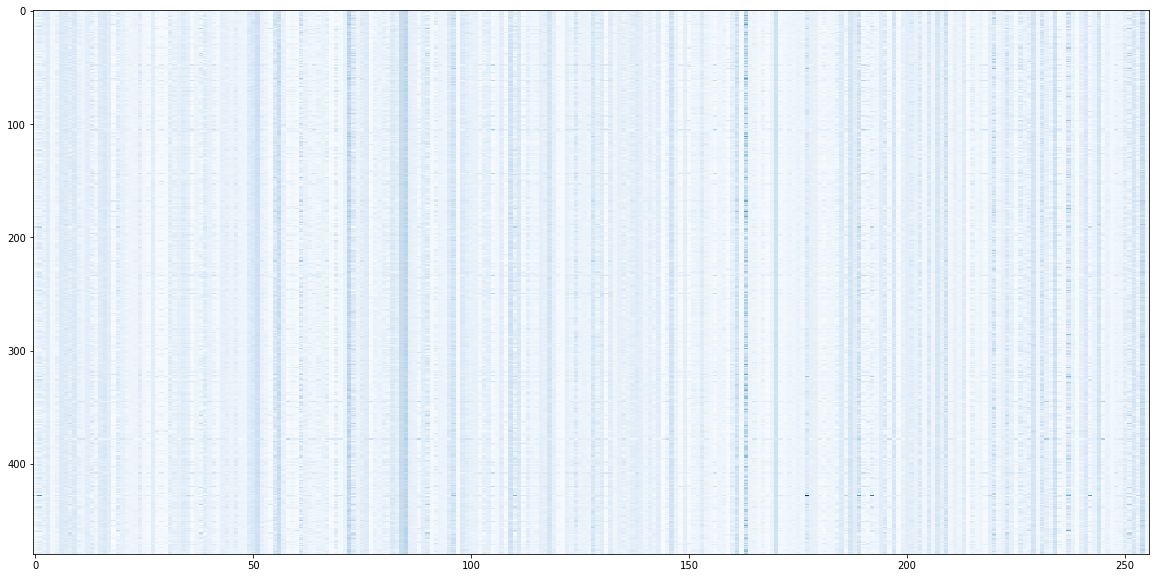

In [23]:
plt.figure(figsize=(20,10))
plt.imshow(to_plot_low,cmap='Blues',aspect='auto')

In [39]:
blks[1]

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)

In [60]:
ks = [112,112,112,56,56,28,14,7,1]

In [61]:
len(ks)

9

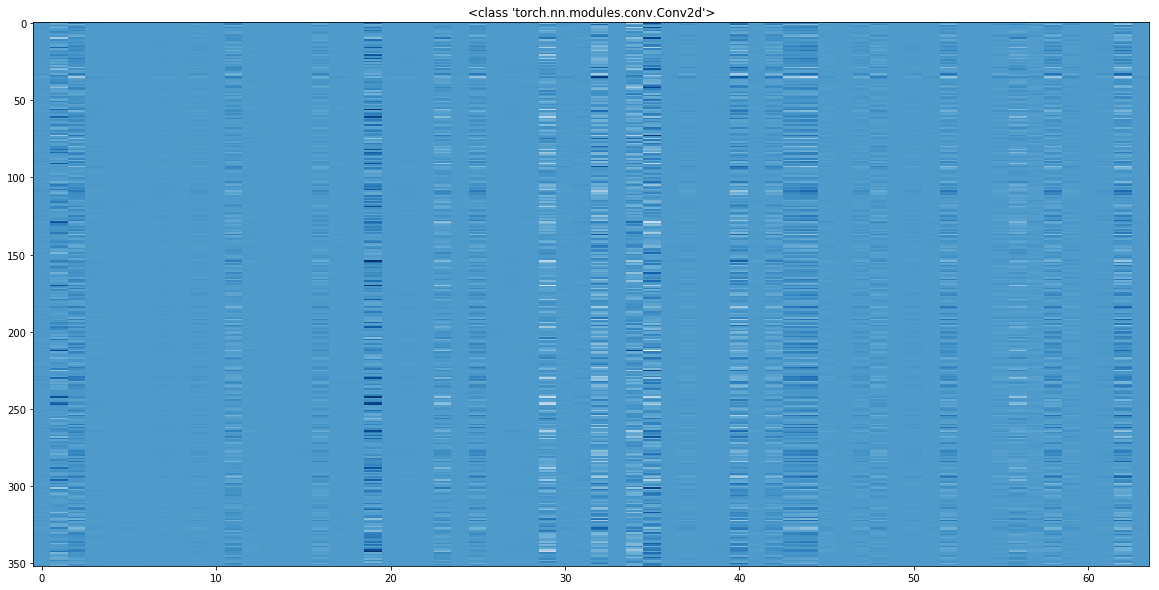

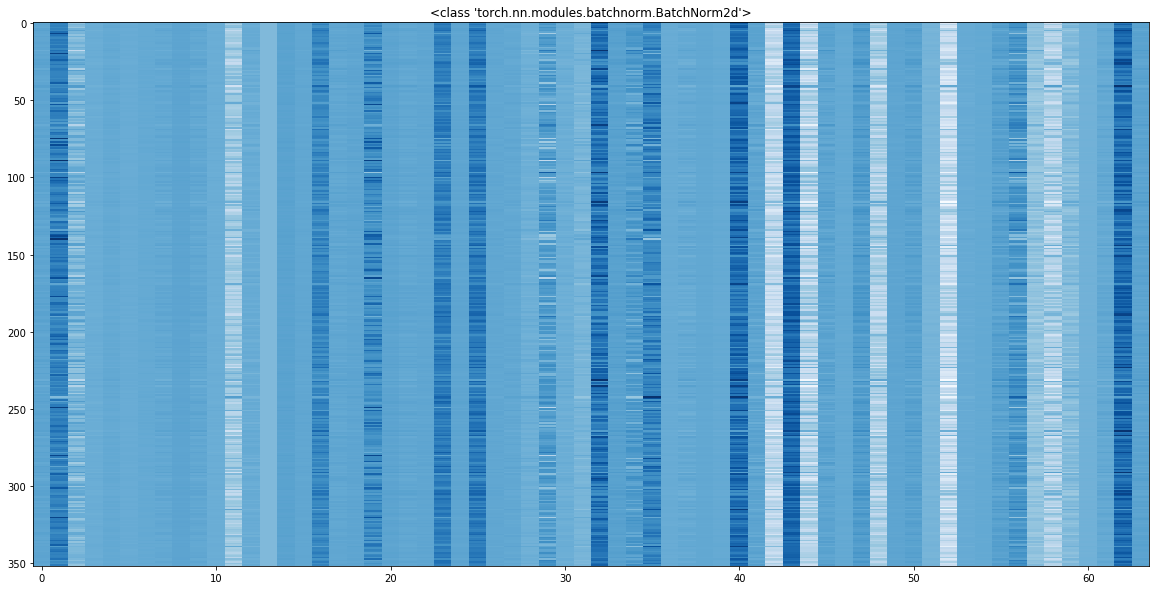

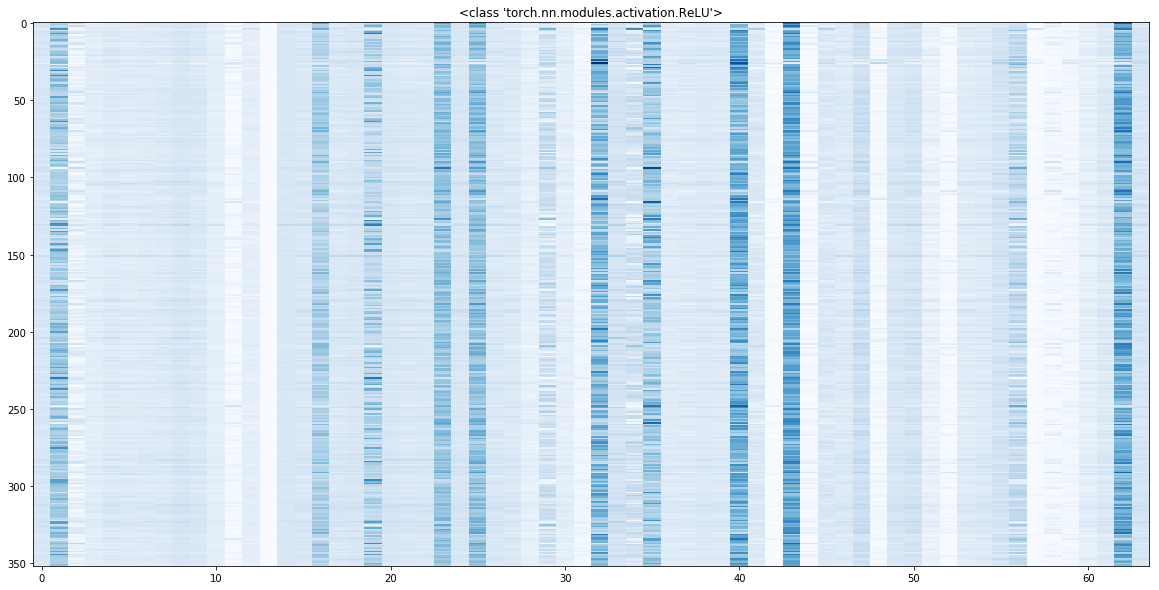

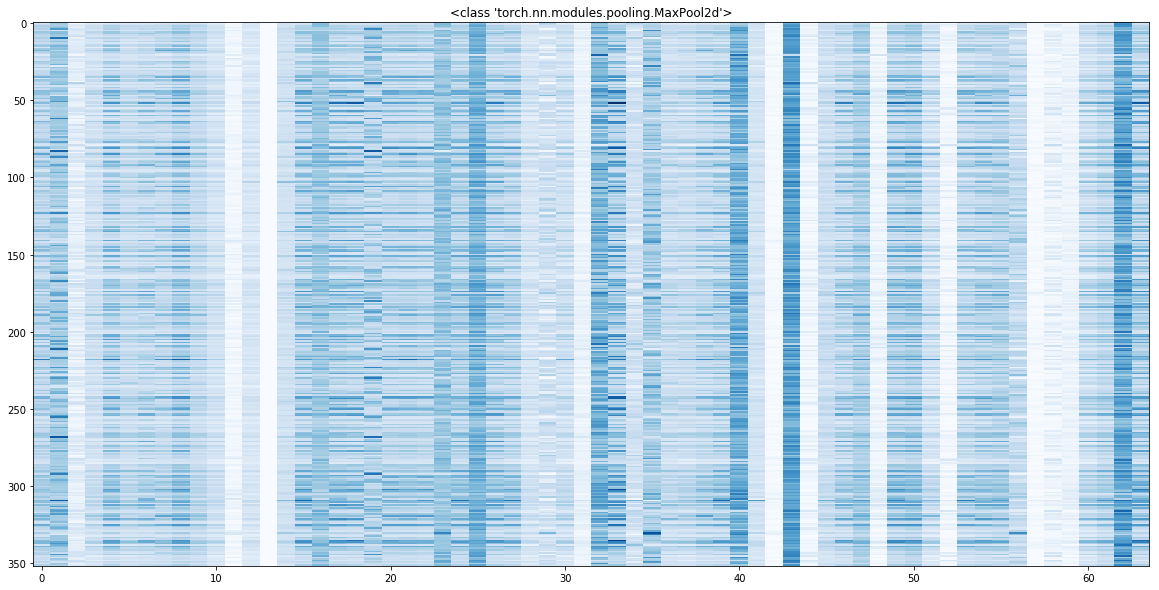

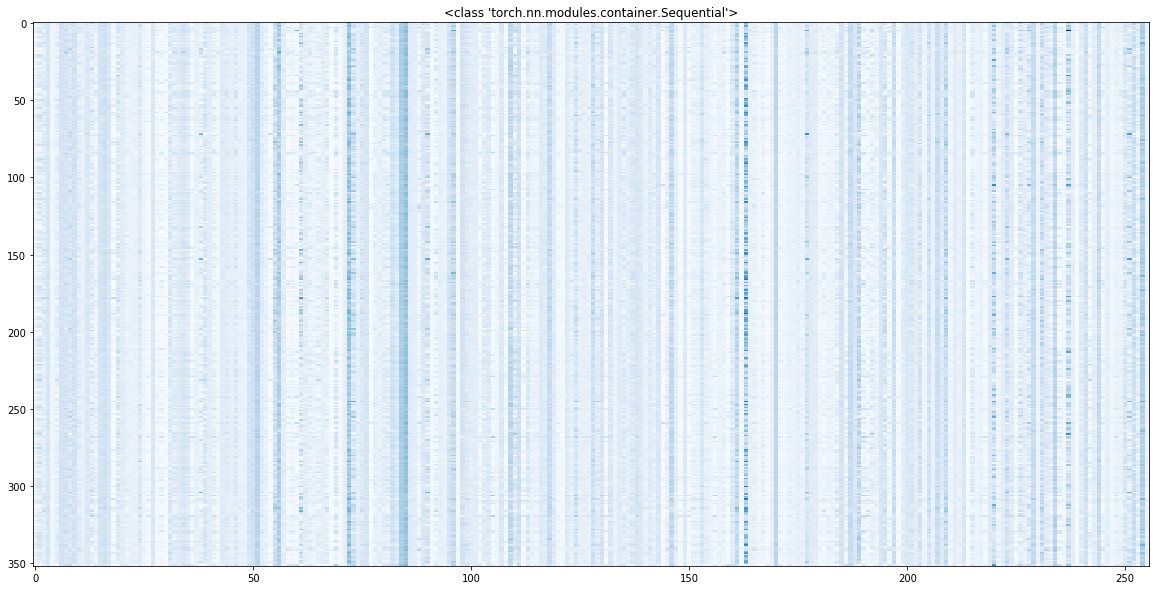

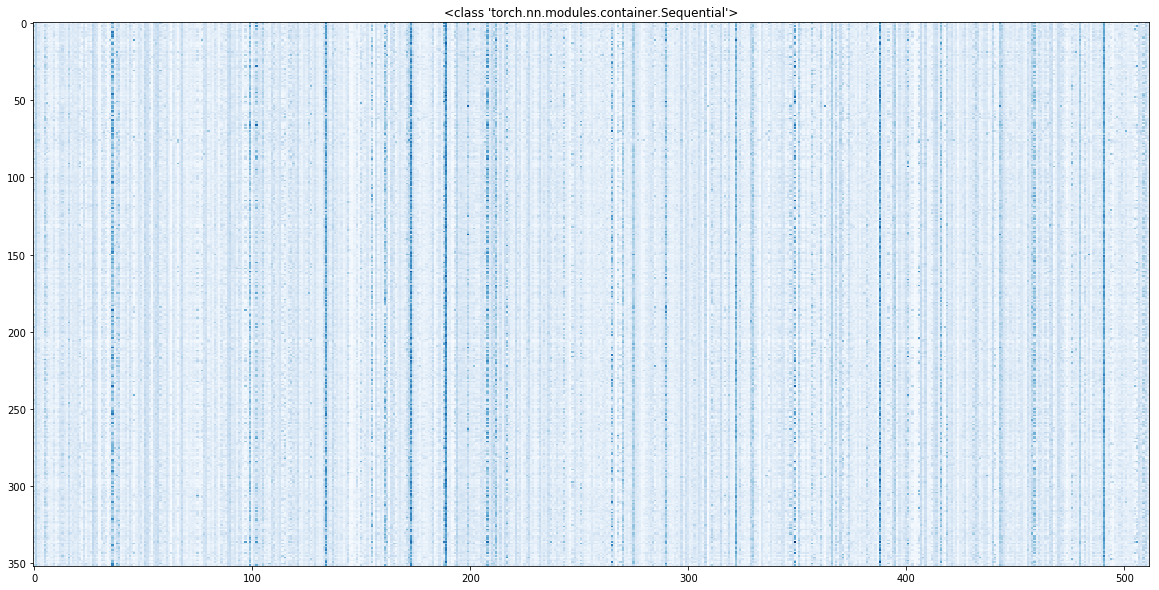

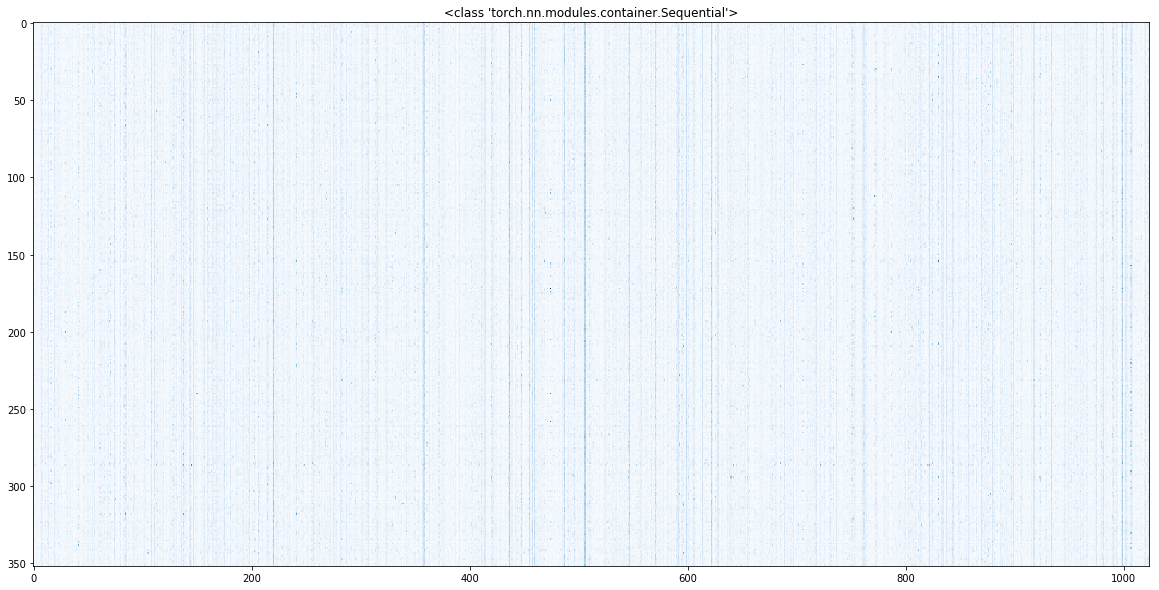

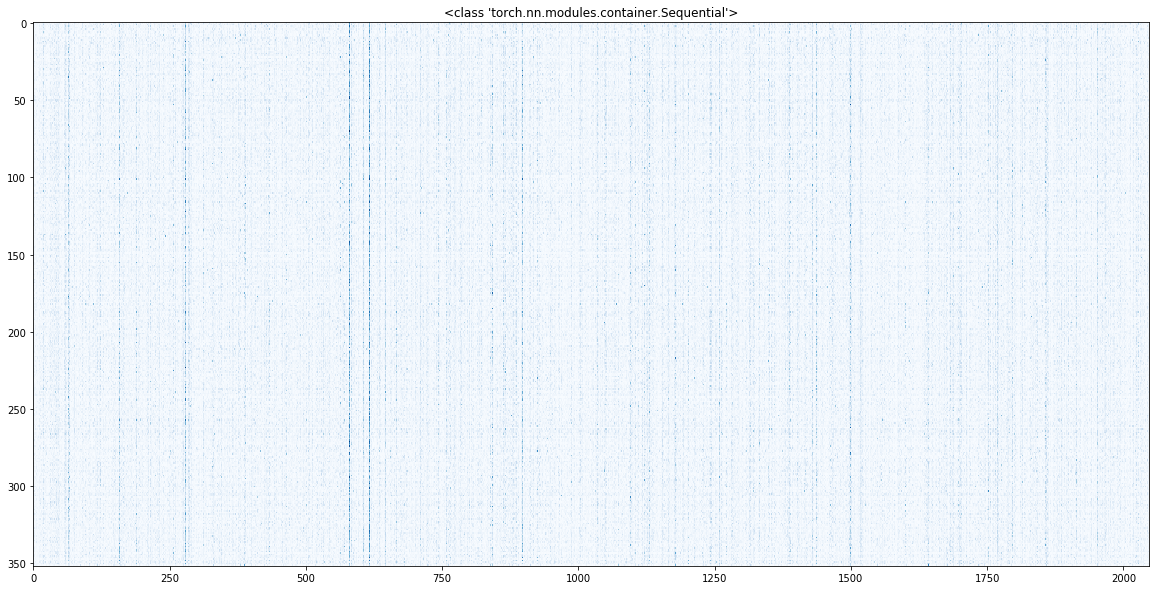

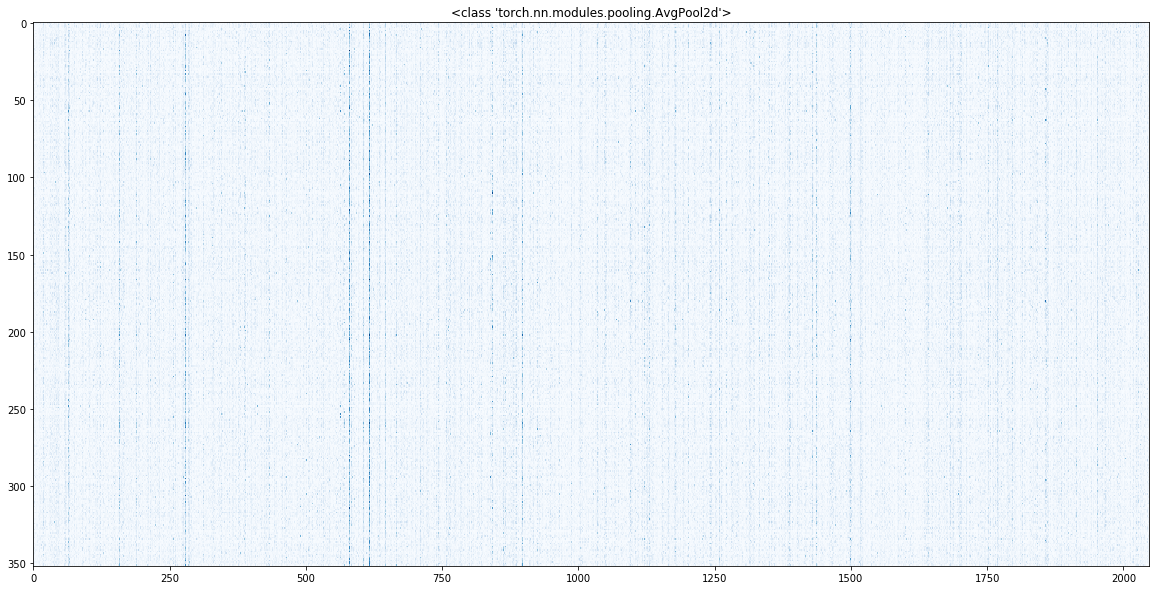

In [62]:
for j in range(9):
    first_conv = []
    for batch, _ in iter(trainloader):
        out = Variable(batch).cuda()
        for i, layer in enumerate(blks):
            out = layer(out)
            if i == j:
                out = torch.nn.functional.avg_pool2d(out, kernel_size=ks[j])
                first_conv.append(out.squeeze().data.cpu().numpy())
                break
        if len(first_conv) > 10:
            break
    to_plot_conv = np.vstack(first_conv)
    plt.figure(figsize=(20,10))
    plt.imshow(to_plot_conv,cmap='Blues',aspect='auto')
    plt.title(str(type(blks[j])))